In [2]:
# import urllib
# import urllib.request

# file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

# print('Downloading data file - this may take a while, patience...')
# password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
# password_mgr.add_password(None, file_url, "Bu5OJl7kfP3bBT4", "HS2")
# handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
# opener = urllib.request.build_opener(handler)
# opener.open(file_url)
# urllib.request.install_opener(opener)
# with urllib.request.urlopen(file_url) as response, open('mea1k_data.h5', 'wb') as out_file:
#     data = response.read()
#     out_file.write(data)
# print('...done')

...done


In [3]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import Mea1k
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [16]:
# raw data location
data_file = 'mea1k_data.h5'

# detection parameters
to_localize = True
cutout_start = 16
cutout_end = 34
threshold = 2
file_directory = 'results/'
file_name = 'ProcessedSpikes_mea1k'

In [17]:
Probe = Mea1k(data_file)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name,
                file_directory_name=file_directory)

In [18]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 20000
# Localization On
# Not Masking any Channels
# Number of recorded channels: 69
# Analysing frames: 4450600, Seconds:222.53
# Frames before spike in cutout: 20
# Frames after spike in cutout: 44
# tcuts: 32 46
# tInc: 50000
# Analysing 50000 frames; from -32 to 50046
# Analysing 50000 frames; from 49968 to 100046
# Analysing 50000 frames; from 99968 to 150046
# Analysing 50000 frames; from 149968 to 200046
# Analysing 50000 frames; from 199968 to 250046
# Analysing 50000 frames; from 249968 to 300046
# Analysing 50000 frames; from 299968 to 350046
# Analysing 50000 frames; from 349968 to 400046
# Analysing 50000 frames; from 399968 to 450046
# Analysing 50000 frames; from 449968 to 500046
# Analysing 50000 frames; from 499968 to 550046
# Analysing 50000 frames; from 549968 to 600046
# Analysing 50000 frames; from 599968 to 650046
# Analysing 50000 frames; from 649968 to 700046
# Analysing 50000 frames; from 699968 to 750046
# Analysing 50000 frames; from 749968 to

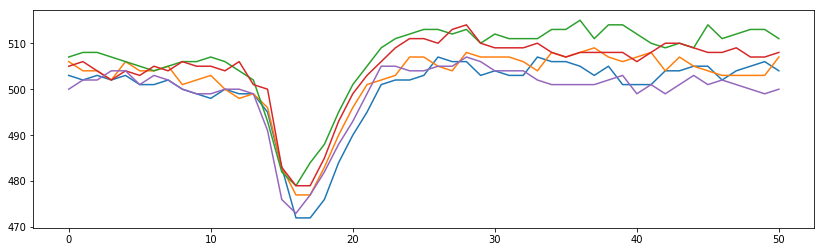

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(2536, 51)


In [14]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (2028, 51)
Test Datasize: (508, 51)


In [12]:
from sklearn.decomposition import PCA


def find_scaled_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.var(original[i, :])
        mse.append(np.mean(se))
    mse = np.array(mse)

# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(10,10))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=True, notch=False)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    for i in keys:
        print(i, np.median(corrs[i]))
    gen_boxplots(corrs)

def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_train.shape[0], embedding])
    out_final = np.zeros([electrode_data_train.shape[0], length])

#     for i in range(electrode_data_test.shape[0]):
#         data = electrode_data_test[i, :]
#         data = data.reshape(1, 51)
    data = torch.from_numpy(electrode_data_train).float()

    enc, o = model.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()

    #enc_final[i, :] = enc[:]
    #out_final[i, :] = o[:]

    return enc, o

PCA 0.9832537053274004


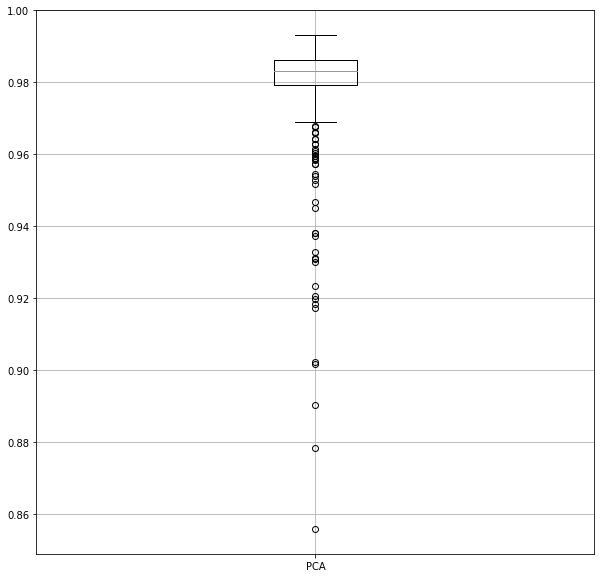

In [15]:
#_, out = get_network_output(ae_1, 2)
out_pca = comp_pca(4)
d = {'PCA': out_pca}
find_correlation_coeff(d)